In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geographiclib.geodesic import Geodesic
import math
from cmdstanpy import CmdStanModel, set_cmdstan_path
import os
import arviz as az

CMDSTAN_PATH = "/home/klemen/micromamba/envs/gps/bin/cmdstan"
KNOWN_POINTS_CSV = 'NM/known_points.csv'
REF_POINTS_CSV = 'NM/points.csv'
STAN_MODEL_PATH = 'model.stan'
set_cmdstan_path(CMDSTAN_PATH)

# Quick sanity check
assert KNOWN_POINTS_CSV != REF_POINTS_CSV
assert KNOWN_POINTS_CSV.split('/')[0] == REF_POINTS_CSV.split('/')[0] # Ensure the data is from the same area

def read_known_points(known_csv):
    df = pd.read_csv(known_csv)
    print(f"Read {len(df)} known points from {known_csv}")
    assert len(df) == np.unique(df['name']).shape[0]
    return df

# Our goal is to assist the investigation by providing a relative quantification of whether the the device was at the proposed points P1, P2... when it took the evidence E due to GPS error.
known_points_df = read_known_points(KNOWN_POINTS_CSV)
known_points_df

Read 4 known points from NM/known_points.csv


,name,lat,lng
0,P1,45.828472,15.220485
1,P2,45.828432,15.220255
2,P3,45.828386,15.220487
3,E,45.828369,15.220408


In [16]:
def lat_lng2dist_ang(center_point_lat_lng, target_point_lat_lng):
    # center_point_lat_lng = [lat, lng] this is one of the known proposal points (not the evidence point)
    # target_point_lat_lng = [lat, lng] this is one of the measured points for the proposal, can also be the evidence point
    # computes distance (in meters) between two points and azimuth (angle from north in radians) of the line using WGS84 ellipsoid, line spins around center_point_lat_lng
    # computes angle (in radians and degrees) between two points
    results = Geodesic.WGS84.Inverse(center_point_lat_lng[0], center_point_lat_lng[1], target_point_lat_lng[0], target_point_lat_lng[1])
    distance = results['s12']
    angle_deg = results['azi1']
    angle = math.radians(angle_deg)
    return distance, angle, angle_deg

def prepare_measurements_for_proposal(ref_csv, proposal_name, known_points_df):
    proposal_lat_lng = known_points_df[known_points_df['name'] == proposal_name][['lat', 'lng']].values[0].tolist()
    print(f"Proposal {proposal_name} lat, lng: {proposal_lat_lng}")
    df = pd.read_csv(ref_csv)
    needed_columns = ['datetime', 'measured_from', 'lat', 'lng', 'precise']
    df = df[needed_columns]
    df = df[df['measured_from'] == proposal_name]
    df = df[df['precise'] == 'on']
    df = df.drop(columns=['precise'])
    df = df.sort_values(by='datetime', ascending=True, ignore_index=True)
    # flag indicating if two consecutive (by datetime) measurements  are the same (lat, lng)
    df['same_as_prev'] = df[['lat', 'lng']].duplicated(keep='first')
    num_rows = df.shape[0]
    num_duplicates = df['same_as_prev'].sum()
    print(f"Number of measurements for proposal {proposal_name}: {num_rows}")
    print(f"Number of duplicate consecutive measurements: {num_duplicates} ({num_duplicates/num_rows*100:.2f}%)")
    # remove duplicate consecutive measurements
    df = df[df['same_as_prev'] == False]
    df = df.drop(columns=['same_as_prev'])
    df = df.reset_index(drop=True)


    
    df["dist"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[0], axis=1)
    df["angle"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[1], axis=1)
    df["angle_deg"] = df.apply(lambda x: lat_lng2dist_ang(proposal_lat_lng, [x["lat"], x["lng"]])[2], axis=1)

    
    print(f"Clean measurements for proposal {proposal_name}: {df.shape[0]}")
    display(df)
    display(df.describe())
    return df

p1_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P1', known_points_df)
p2_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P2', known_points_df)
p3_measurements = prepare_measurements_for_proposal(REF_POINTS_CSV, 'P3', known_points_df)


Proposal P1 lat, lng: [45.82847186111111, 15.22048538888889]
Number of measurements for proposal P1: 100
Number of duplicate consecutive measurements: 75 (75.00%)
Clean measurements for proposal P1: 25


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:27 13:32:27,P1,45.828472,15.220483,0.164687,-1.324602,-75.894089
1,2024:04:27 13:32:28,P1,45.828475,15.220481,0.512605,-0.822210,-47.109157
2,2024:04:27 13:32:28,P1,45.828475,15.220475,0.879406,-1.162852,-66.626492
3,2024:04:27 13:32:31,P1,45.828481,15.220478,1.132972,-0.549183,-31.465878
4,2024:04:27 13:32:34,P1,45.828472,15.220486,0.068994,0.949931,54.427021
5,2024:04:27 13:32:38,P1,45.828475,15.220489,0.442356,0.662125,37.936951
6,2024:04:27 13:32:39,P1,45.828475,15.220494,0.785381,1.110494,63.626633
7,2024:04:27 13:32:40,P1,45.828475,15.220492,0.599721,0.949931,54.427019
8,2024:04:27 13:32:44,P1,45.828472,15.220489,0.274904,1.424270,81.604641
9,2024:04:27 13:32:46,P1,45.828472,15.220492,0.489446,1.488700,85.296208


,lat,lng,dist,angle,angle_deg
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,45.828471,15.220484,0.593417,-0.020074,-1.150145
std,0.000004,0.000006,0.273815,1.933889,110.803656
min,45.828464,15.220475,0.068994,-2.963255,-169.781990
25%,45.828469,15.220481,0.382245,-1.503033,-86.117443
50%,45.828472,15.220483,0.592761,-0.549183,-31.465878
75%,45.828475,15.220489,0.808238,1.488700,85.296208
max,45.828481,15.220494,1.132972,3.078345,176.376177


Proposal P2 lat, lng: [45.82843192982457, 15.220255146198827]
Number of measurements for proposal P2: 95
Number of duplicate consecutive measurements: 70 (73.68%)
Clean measurements for proposal P2: 25


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:27 13:34:30,P2,45.828456,15.220189,5.779370,-1.099135,-62.975798
1,2024:04:27 13:34:32,P2,45.828431,15.220219,2.778313,-1.625802,-93.151607
2,2024:04:27 13:34:32,P2,45.828433,15.220214,3.209584,-1.522173,-87.214110
3,2024:04:27 13:34:34,P2,45.828425,15.220222,2.671706,-1.863240,-106.755814
4,2024:04:27 13:34:35,P2,45.828425,15.220225,2.465816,-1.888478,-108.201837
5,2024:04:27 13:34:38,P2,45.828425,15.220233,1.861716,-1.997336,-114.438949
6,2024:04:27 13:34:39,P2,45.828425,15.220239,1.479533,-2.118343,-121.372098
7,2024:04:27 13:34:40,P2,45.828431,15.220242,1.058471,-1.715611,-98.297279
8,2024:04:27 13:34:42,P2,45.828431,15.220244,0.845464,-1.752460,-100.408589
9,2024:04:27 13:34:51,P2,45.828431,15.220247,0.634376,-1.813969,-103.932782


,lat,lng,dist,angle,angle_deg
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,45.828433,15.220259,2.123139,0.035224,2.018196
std,0.000007,0.000029,1.064328,1.594077,91.333873
min,45.828425,15.220189,0.429223,-2.118343,-121.372098
25%,45.828431,15.220239,1.550987,-1.715611,-98.297279
50%,45.828431,15.220269,2.195527,0.798518,45.751725
75%,45.828433,15.220283,2.626333,1.511368,86.595015
max,45.828456,15.220294,5.779370,1.657440,94.964293


Proposal P3 lat, lng: [45.82838566784871, 15.220487234042553]
Number of measurements for proposal P3: 94
Number of duplicate consecutive measurements: 80 (85.11%)
Clean measurements for proposal P3: 14


,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:27 13:36:33,P3,45.828431,15.220281,16.816560,-1.269578,-72.741478
1,2024:04:27 13:36:34,P3,45.828431,15.220283,16.610562,-1.265723,-72.520595
2,2024:04:27 13:36:34,P3,45.828425,15.220286,16.227686,-1.298028,-74.371545
3,2024:04:27 13:36:35,P3,45.828425,15.220289,16.019931,-1.294399,-74.163582
4,2024:04:27 13:36:36,P3,45.828422,15.220297,15.313207,-1.302256,-74.613793
5,2024:04:27 13:36:37,P3,45.828422,15.220300,15.105212,-1.298465,-74.396572
6,2024:04:27 13:36:38,P3,45.828419,15.220308,14.399037,-1.307021,-74.886805
7,2024:04:27 13:36:39,P3,45.828414,15.220317,13.619623,-1.338401,-76.684720
8,2024:04:27 13:36:40,P3,45.828411,15.220325,12.919290,-1.350114,-77.355808
9,2024:04:27 13:36:41,P3,45.828408,15.220336,12.009810,-1.359462,-77.891440


,lat,lng,dist,angle,angle_deg
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,45.828411,15.220353,13.525508,-0.876870,-50.240932
std,0.000021,0.000110,2.661178,1.132267,64.874118
min,45.828367,15.220281,9.433322,-1.397740,-80.084621
25%,45.828404,15.220291,11.285619,-1.347185,-77.188036
50%,45.828417,15.220313,14.009330,-1.300361,-74.505182
75%,45.828424,15.220344,15.843250,-1.275783,-73.097004
max,45.828431,15.220608,16.816560,1.796590,102.937050


In [17]:
# visualize points on the map TODO
# fig, ax = plt.subplots()
# sns.scatterplot(data=proposal_ref_points_df, x='lng', y='lat', hue='ref_point')
# sns.scatterplot(data=known_points_df, x='lng', y='lat', hue='name', marker='X', s=100)

In [18]:
# distribution visualizations

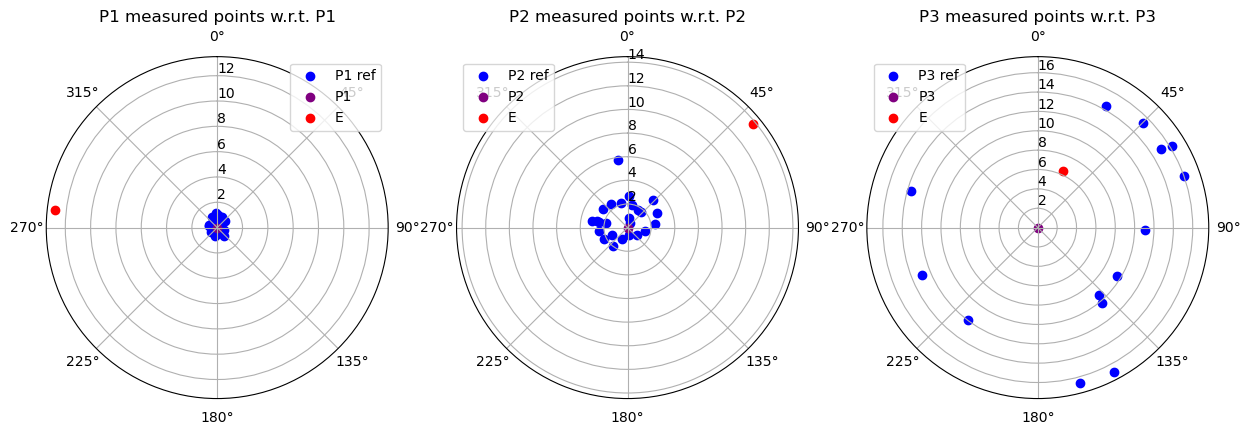

In [19]:
def visualize_polar(proposal_measurements, ax, known_points_df):
    # meters and degrees
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(0)
    ax.set_title(f"{proposal_measurements['measured_from'][0]} measured points w.r.t. {proposal_measurements['measured_from'][0]}")
    ax.scatter(proposal_measurements["angle_deg"], proposal_measurements["dist"], label=f"{proposal_measurements['measured_from'][0]} ref", color="blue")
    ax.scatter(0, 0, label=proposal_measurements['measured_from'][0], color="purple")
    ax.set_rmax(max(proposal_measurements["dist"]))
    # E lat lng to float
    E_lat_lng = known_points_df[known_points_df['name'] == 'E'][['lat', 'lng']].values[0].tolist()
    P_lat_lng = known_points_df[known_points_df['name'] == proposal_measurements['measured_from'][0]][['lat', 'lng']].values[0].tolist()
    E_dist, _, E_angle_deg = lat_lng2dist_ang(P_lat_lng, E_lat_lng)
    ax.scatter(E_angle_deg, E_dist, label='E', color='red')
    ax.legend()
    return ax

fig, ax = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(15,7))
for ax1, proposal_measurements in zip(ax.flatten(), [p1_measurements, p2_measurements, p3_measurements]):
    visualize_polar(proposal_measurements, ax1, known_points_df)
plt.show()


In [20]:
p1_measurements

,datetime,measured_from,lat,lng,dist,angle,angle_deg
0,2024:04:27 13:32:27,P1,45.828472,15.220483,0.164687,-1.324602,-75.894089
1,2024:04:27 13:32:28,P1,45.828475,15.220481,0.512605,-0.822210,-47.109157
2,2024:04:27 13:32:28,P1,45.828475,15.220475,0.879406,-1.162852,-66.626492
3,2024:04:27 13:32:31,P1,45.828481,15.220478,1.132972,-0.549183,-31.465878
4,2024:04:27 13:32:34,P1,45.828472,15.220486,0.068994,0.949931,54.427021
5,2024:04:27 13:32:38,P1,45.828475,15.220489,0.442356,0.662125,37.936951
6,2024:04:27 13:32:39,P1,45.828475,15.220494,0.785381,1.110494,63.626633
7,2024:04:27 13:32:40,P1,45.828475,15.220492,0.599721,0.949931,54.427019
8,2024:04:27 13:32:44,P1,45.828472,15.220489,0.274904,1.424270,81.604641
9,2024:04:27 13:32:46,P1,45.828472,15.220492,0.489446,1.488700,85.296208


In [21]:
stan_model = CmdStanModel(stan_file=STAN_MODEL_PATH)
data = {
    'n' : len(p1_measurements),
    'dist_ang' : p1_measurements.loc[:, ['dist', 'angle']].values
}


fit = stan_model.sample(data=data, chains=4, iter_warmup=1000, iter_sampling=4000, seed=1, adapt_delta=0.96, parallel_chains=os.cpu_count() // 2)
fit.summary()

23:28:41 - cmdstanpy - INFO - compiling stan file /home/klemen/programming/gps_evaluation/model.stan to exe file /home/klemen/programming/gps_evaluation/model
23:29:09 - cmdstanpy - INFO - compiled model executable: /home/klemen/programming/gps_evaluation/model
23:29:09 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration:  500 / 5000 [ 10%]  (Warmup)


chain 1 |███▋      | 00:00 Iteration: 1600 / 5000 [ 32%]  (Sampling)


chain 1 |█████▊    | 00:00 Iteration: 2700 / 5000 [ 54%]  (Sampling)


chain 1 |███████▉  | 00:00 Iteration: 3800 / 5000 [ 76%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


23:29:10 - cmdstanpy - INFO - CmdStan done processing.
23:29:10 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is 0. (in 'model.stan', line 12, column 4 to column 39)
Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'model.stan', line 12, column 4 to column 39)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'model.stan', line 12, column 4 to column 39)
	Exception: multi_normal_lpdf: LDLT_Factor of covariance parameter is not positive definite.  last conditional variance is -nan. (in 'model.stan', line 12, column 4 to column 39)
	Exception: multi_normal_lpdf: Covariance matrix is not symmetric. Covariance matrix[1,2] = -nan, but Covariance matrix[2,1] = -nan (in 'model.stan', line 12, co

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-11.775100,0.023456,1.734440,-15.148800,-11.419800,-9.662810,5467.74,3456.22,1.00032
mu[1],0.593597,0.000584,0.063776,0.490021,0.593641,0.696828,11909.30,7527.98,1.00031
mu[2],-0.018832,0.003915,0.439647,-0.749445,-0.018873,0.700310,12614.00,7973.45,1.00002
"sigma[1,1]",0.100636,0.000371,0.036468,0.057367,0.093409,0.167805,9666.11,6110.06,0.99996
"sigma[1,2]",-0.089268,0.001813,0.177955,-0.392020,-0.081401,0.172775,9634.25,6089.92,1.00058
"sigma[2,1]",-0.089268,0.001813,0.177955,-0.392020,-0.081401,0.172775,9634.25,6089.92,1.00058
"sigma[2,2]",4.993170,0.018427,1.738270,2.876340,4.651700,8.247480,8898.70,5624.97,1.00003


array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n0'}>],
       [<Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n1'}>],
       [<Axes: title={'center': 'sigma\n0, 0'}>,
        <Axes: title={'center': 'sigma\n0, 0'}>],
       [<Axes: title={'center': 'sigma\n0, 1'}>,
        <Axes: title={'center': 'sigma\n0, 1'}>],
       [<Axes: title={'center': 'sigma\n1, 0'}>,
        <Axes: title={'center': 'sigma\n1, 0'}>],
       [<Axes: title={'center': 'sigma\n1, 1'}>,
        <Axes: title={'center': 'sigma\n1, 1'}>]], dtype=object)

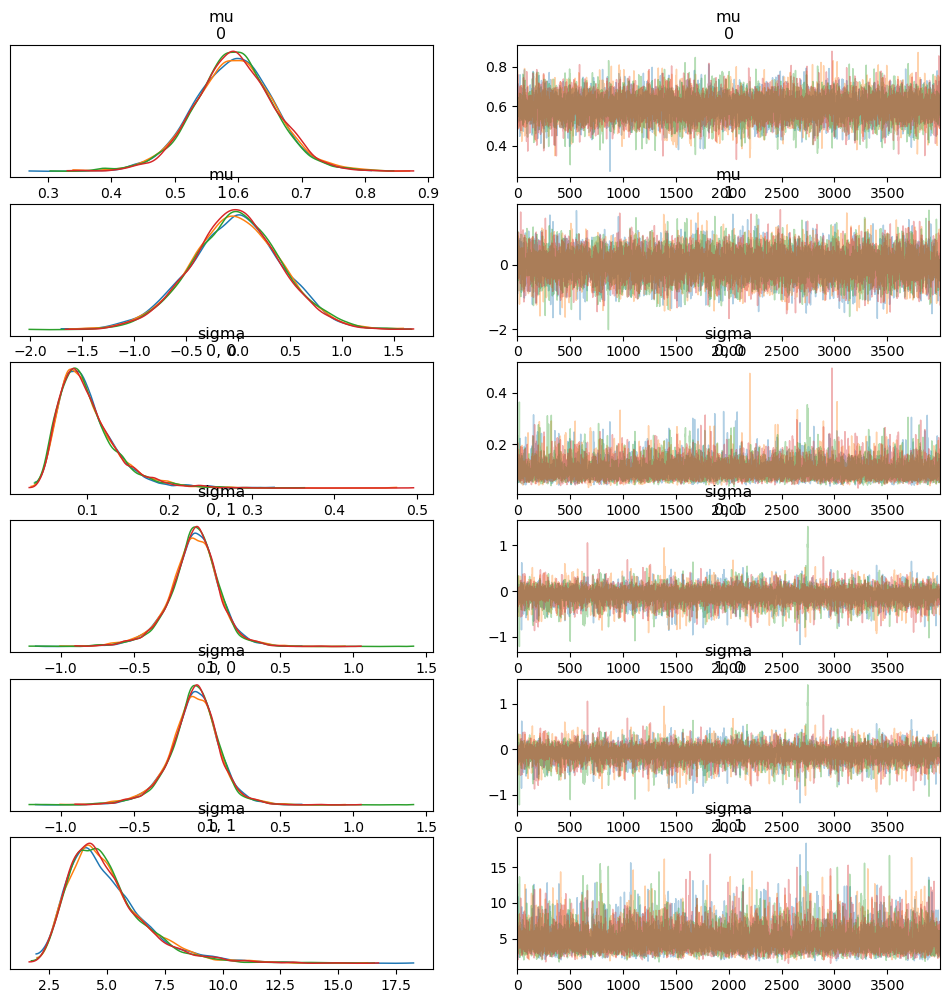

In [22]:
# traceplots
az.plot_trace(fit, compact=False)

In [23]:
print(fit.diagnose())

Processing csv files: /tmp/tmpg236fi3b/modelb6a4rxem/model-20240730232909_1.csv, /tmp/tmpg236fi3b/modelb6a4rxem/model-20240730232909_2.csv, /tmp/tmpg236fi3b/modelb6a4rxem/model-20240730232909_3.csv, /tmp/tmpg236fi3b/modelb6a4rxem/model-20240730232909_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [24]:
draws_df = fit.draws_pd()
draws_df

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu[1],mu[2],"sigma[1,1]","sigma[2,1]","sigma[1,2]","sigma[2,2]"
0,1.0,1.0,1.0,-11.65210,0.992868,0.391376,4.0,15.0,0.0,14.2955,0.598319,-0.114475,0.048161,0.010065,0.010065,5.26311
1,1.0,2.0,2.0,-10.89350,0.987384,0.391376,3.0,7.0,0.0,13.9255,0.532922,0.552446,0.087488,0.003929,0.003929,3.79607
2,1.0,3.0,3.0,-12.34990,0.925092,0.391376,3.0,7.0,0.0,15.1165,0.682921,-0.907473,0.073188,-0.117894,-0.117894,5.25361
3,1.0,4.0,4.0,-12.45360,0.954155,0.391376,3.0,15.0,0.0,16.6742,0.625745,-0.344948,0.162409,-0.469705,-0.469705,6.38070
4,1.0,5.0,5.0,-15.78540,0.948330,0.391376,3.0,7.0,0.0,18.8327,0.517421,-0.214914,0.063506,-0.281956,-0.281956,10.89300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,4.0,3996.0,15996.0,-10.66050,0.983155,0.449149,3.0,7.0,0.0,14.4588,0.590681,0.437829,0.113381,0.056185,0.056185,4.31526
15996,4.0,3997.0,15997.0,-9.78592,1.000000,0.449149,3.0,7.0,0.0,10.9104,0.619970,0.061993,0.112112,-0.015085,-0.015085,4.04260
15997,4.0,3998.0,15998.0,-11.03190,0.952897,0.449149,3.0,7.0,0.0,11.8261,0.611975,0.011191,0.055242,-0.157368,-0.157368,4.95994
15998,4.0,3999.0,15999.0,-11.19110,0.930772,0.449149,3.0,7.0,0.0,13.2692,0.486638,0.086602,0.092637,0.003308,0.003308,4.93887


## Posterior predictive check